In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


#Scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import csv
import time

#BNN
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [21]:
# Load .env file
load_dotenv('../.env.local')  # Adjust the relative path according to your directory structure

# Get the project path from environment variables
project_path = os.getenv('MY_PROJECT_PATH')

# Read CSV into DataFrame
df = pd.read_csv(project_path)

In [26]:
# Display the DataFrame
df.head()

,Unnamed: 0,Rank,Champion Name,Tier,Win rate,Pick Rate,Ban Rate,Matches,gameDuration,allInPings,...,turretTakedowns_y,turretsTakenWithRiftHerald,twentyMinionsIn3SecondsCount,twoWardsOneSweeperCount,unseenRecalls,visionScoreAdvantageLaneOpponent,visionScorePerMinute,wardTakedowns,wardTakedownsBefore20M,wardsGuarded
0,0,1,Swain,S,53.87,12.0,1.7,19216,1711,0,...,7,0,4,0,0,0.731238,1.166228,4,2,1
1,1,1,Swain,S,53.87,12.0,1.7,19216,1987,0,...,1,0,9,0,0,-0.407494,0.594141,1,1,0
2,2,1,Swain,S,53.87,12.0,1.7,19216,1495,0,...,1,0,8,0,0,-0.782050,0.388326,1,0,0
3,3,1,Swain,S,53.87,12.0,1.7,19216,1528,1,...,1,5,6,0,0,-0.055465,0.637202,4,3,0
4,4,1,Swain,S,53.87,12.0,1.7,19216,1155,0,...,0,0,1,0,0,-0.218048,1.941728,1,1,0


In [23]:
url = "https://u.gg/lol/profile/euw1/thehighground/champion-stats"

options = Options()
options.add_argument("--headless")
options.binary_location = "C:\\Users\\nicol\\Downloads\\chrome-win64\\chrome-win64\\chrome.exe"  # Path to your Chrome executable

service = Service("C:\\Users\\nicol\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

driver.get(url)

wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.rt-tr-group")))

data = []  # List to store each row of data

while True:
    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    
    # Scroll back to the top of the page
    driver.execute_script("window.scrollTo(0, 0);")
    time.sleep(1)
    
    # Check if all rows have been loaded
    rows = driver.find_elements(By.CSS_SELECTOR, "div.rt-tr-group")
    if not rows or len(data) == len(rows):  # Adjusted condition to check data length instead of champions length
        break
    
    # Otherwise, continue to extract the data
    for i in range(len(data), len(rows)):
        row = rows[i]
        try:
            name = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(2)").text.strip()
            rank = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(1)").text.strip()
            champion = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(3)").get_attribute("textContent")
            winrate_stats = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(4)").text.strip()
            win_rate = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(5)").text.strip()
            pick_rate = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(7)").text.strip()
            ban_rate = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(6)").text.strip()
            matches = row.find_element(By.CSS_SELECTOR, "div.rt-td:nth-of-type(8)").text.strip()
    
            # Append the extracted data to the data list
            data.append([rank, name, champion, winrate_stats, win_rate, pick_rate,ban_rate, matches])
        
        except Exception as e:
            print(f"Error in row {i}: {e}")


# Convert the data list into a pandas DataFrame
columns = ['Rank', 'Name', 'WinRate', 'KDA', 'Win rate', 'Pick Rate', 'Ban Rate', 'CS']
df_scraped = pd.DataFrame(data, columns=columns)

driver.quit()

df_scraped.head()

,Rank,Name,WinRate,KDA,Win rate,Pick Rate,Ban Rate,CS
0,1,Vex,100% / 7W 0L,3.19\n6.0 / 4.4 / 8.1,,7,11,178.4
1,2,Xerath,33% / 1W 2L,3.57\n5.0 / 4.7 / 11.7,,10,8,219.7
2,3,Lulu,100% / 2W 0L,8.80\n3.0 / 2.5 / 19.0,,3,5,16.5
3,4,Lux,50% / 1W 1L,5.17\n8.0 / 3.0 / 7.5,,4,8,239.5
4,5,Morgana,50% / 1W 1L,4.20\n3.0 / 2.5 / 7.5,,5,3,14


In [24]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time

url = "https://u.gg/lol/profile/euw1/thehighground/champion-stats"

options = Options()
options.add_argument("--headless")
options.binary_location = "C:\\Users\\nicol\\Downloads\\chrome-win64\\chrome-win64\\chrome.exe"

service = Service("C:\\Users\\nicol\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

driver.get(url)

wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.rt-tr-group")))

# ... (your existing imports and setup code)

# Initialize list to store each row of data
data = []

# Get all the rows
rows = driver.find_elements(By.CSS_SELECTOR, "div.rt-tr-group")

for i in range(1, len(rows) + 1):  # start from 1 because CSS nth-child starts from 1
    try:
        # Create CSS selectors based on the row number for each column
        selectors = {
            'Champion': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(2) > div:nth-child(1) > span:nth-child(2)",
            'WinRate': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > span:nth-child(3)",
            'StrongRate': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > strong:nth-child(1)",
            'KDA': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(4) > div:nth-child(1) > div:nth-child(1) > strong:nth-child(1)",
            'LP': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(5) > span:nth-child(1)",
            'MaxKills': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(6) > span:nth-child(1)",
            'MaxDeaths': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(7)",
            'CS': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(8) > span:nth-child(1)",
            'Damage': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(9) > span:nth-child(1)",
            'Gold': f"div.rt-tr-group:nth-child({i}) > div:nth-child(1) > div:nth-child(10) > span:nth-child(1)"
        }
        
        # Find the elements and extract the text
        row_data = []
        for key, selector in selectors.items():
            element = driver.find_element(By.CSS_SELECTOR, selector)
            text = element.text.strip() if element.text else 'N/A'
            row_data.append(text)
        
        # Append to data list
        data.append(row_data)
        
    except Exception as e:
        print(f"Error in row {i}: {e}")

# Convert the data to a DataFrame
columns = ['Champion', 'WinsLoses', 'Winrate', 'KDA', 'LP', 'MaxKills', 'MaxDeaths', 'CS', 'Damage', 'Gold']
df_individual = pd.DataFrame(data, columns=columns)

# Close the driver
driver.quit()

# Display the DataFrame (you could also save it to a file)
df_individual.head()

,Champion,WinsLoses,Winrate,KDA,LP,MaxKills,MaxDeaths,CS,Damage,Gold
0,Vex,7W 0L,100%,3.19,N/A,11,7,178.4,N/A,N/A
1,Xerath,1W 2L,33%,3.57,N/A,8,10,219.7,N/A,N/A
2,Lulu,2W 0L,100%,8.80,N/A,5,3,16.5,N/A,N/A
3,Lux,1W 1L,50%,5.17,N/A,8,4,239.5,N/A,N/A
4,Morgana,1W 1L,50%,4.20,N/A,3,5,14,N/A,N/A


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Data Preprocessing
# Select features and target
feature_columns = ['Tier', 'Win rate', 'Pick Rate', 'Ban Rate', 'Matches', 'gameDuration', 'championId', 'summonerLevel', 'teamId']
target_column = 'win'

# Handle categorical variables and fill NaNs
df[feature_columns] = df[feature_columns].apply(lambda x: x.astype('category').cat.codes if x.dtype == 'object' else x)
df[feature_columns] = df[feature_columns].fillna(df[feature_columns].mean())

# Split data into training and testing sets
X = df[feature_columns].values
Y = df[target_column].values

# Scale the features
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Convert to PyTorch tensors
x, y = torch.from_numpy(X_scaled).float(), torch.from_numpy(Y).long()

# Step 2: Define Model
model = nn.Sequential(
    nn.Linear(in_features=len(feature_columns), out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=2)
)

ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Train Model
for step in range(10000):
    pre = model(x)
    ce = ce_loss(pre, y)
    
    optimizer.zero_grad()
    ce.backward()
    optimizer.step()

_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f' % (ce.item()))

# Step 4: Test Model
# ... (You can use your own visualization method similar to draw_plot function)


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
plot_confusion_matrix(y.numpy(), predicted.numpy())

- Accuracy: 50.514900 %
- CE : 0.70, KL : 0.07


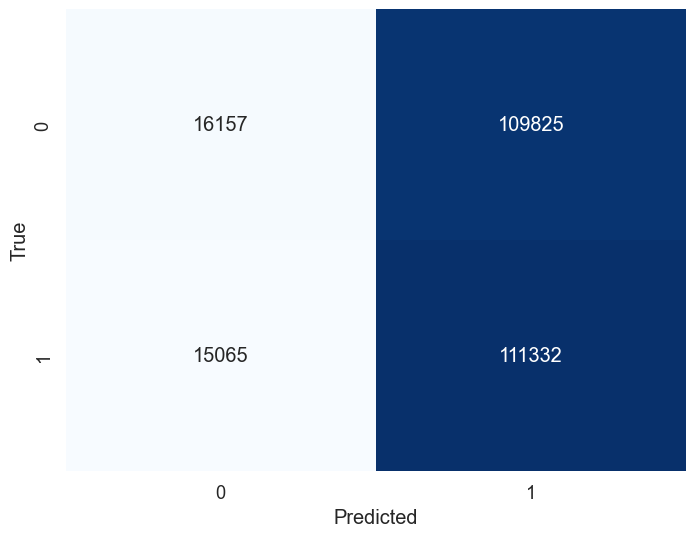

In [33]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=len(feature_columns), out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=2),
)

# Loss and Optimizer
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train Model
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + 0.1 * kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

# Confusion Matrix Function
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Visualization
plot_confusion_matrix(y.numpy(), predicted.numpy())

In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

# URL
url = "https://u.gg/lol/profile/euw1/thehighground/champion-stats"

options = Options()
options.add_argument("--headless")
options.binary_location = "C:\\Users\\nicol\\Downloads\\chrome-win64\\chrome-win64\\chrome.exe"

service = Service("C:\\Users\\nicol\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

driver.get(url)

wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.rt-tr-group")))

# Initialize list to store each row of data
data = []

# Get page source and create BeautifulSoup object
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Close the driver
driver.quit()

# Get all the rows using BeautifulSoup
rows = soup.select("div.rt-tr-group")

for i, row in enumerate(rows, 1):  # start from 1 because CSS nth-child starts from 1
    try:
        selectors = {
            'Champion': "div:nth-child(1) > div:nth-child(2) > div:nth-child(1) > span:nth-child(2)",
            'WinsLoses': "div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > span:nth-child(3)",
            'Winrate': "div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > strong:nth-child(1)",
            'KDA': "div:nth-child(1) > div:nth-child(4) > div:nth-child(1) > div:nth-child(1) > strong:nth-child(1)",
            'KillsDeathsAssists': "div:nth-child(1) > div:nth-child(4) > div:nth-child(1) > span:nth-child(2)",  # New field
            'LP': "div:nth-child(1) > div:nth-child(5) > span:nth-child(1)",
            'MaxKills': "div:nth-child(1) > div:nth-child(6) > span:nth-child(1)",
            'MaxDeaths': "div:nth-child(1) > div:nth-child(7)",
            'CS': "div:nth-child(1) > div:nth-child(8) > span:nth-child(1)",
            'Damage': "div:nth-child(1) > div:nth-child(9) > span:nth-child(1)",
            'Gold': "div:nth-child(1) > div:nth-child(10) > span:nth-child(1)"
        }
        
        row_data = []
        for key, selector in selectors.items():
            element = row.select_one(selector)
            text = element.get_text(strip=True) if element else 'N/A'
            row_data.append(text)
        
        data.append(row_data)
        
    except Exception as e:
        print(f"Error in row {i}: {e}")

# Convert the data to a DataFrame
columns = ['Champion', 'WinsLoses', 'Winrate', 'KDA', 'KillsDeathsAssists', 'LP', 'MaxKills', 'MaxDeaths', 'CS', 'Damage', 'Gold']
df_individual = pd.DataFrame(data, columns=columns)

# Display the DataFrame
df_individual.head()

,Champion,WinsLoses,Winrate,KDA,KillsDeathsAssists,LP,MaxKills,MaxDeaths,CS,Damage,Gold
0,Vex,7W 0L,100%,3.19,6.0/4.4/8.1,0LP,11,7,178.4,"20,298","10,644"
1,Xerath,1W 2L,33%,3.57,5.0/4.7/11.7,0LP,8,10,219.7,"27,957","13,369"
2,Lulu,2W 0L,100%,8.80,3.0/2.5/19.0,36LP,5,3,16.5,"7,046","9,397"
3,Lux,1W 1L,50%,5.17,8.0/3.0/7.5,0LP,8,4,239.5,"24,557","13,452"
4,Morgana,1W 1L,50%,4.20,3.0/2.5/7.5,0LP,3,5,14,"13,531","6,904"


In [17]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

# URL
url = "https://u.gg/lol/profile/euw1/leaguify/champion-stats?queueType=normal_draft_5x5"

options = Options()
options.add_argument("--headless")
options.binary_location = "C:\\Users\\nicol\\Downloads\\chrome-win64\\chrome-win64\\chrome.exe"

service = Service("C:\\Users\\nicol\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

driver.get(url)

wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.rt-tr-group")))

# Initialize list to store each row of data
data = []

# Get page source and create BeautifulSoup object
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Close the driver
driver.quit()

# Get all the rows using BeautifulSoup
rows = soup.select("div.rt-tr-group")

for i, row in enumerate(rows, 1):  # start from 1 because CSS nth-child starts from 1
    try:
        selectors = {
            'Champion': "div:nth-child(1) > div:nth-child(2) > div:nth-child(1) > span:nth-child(2)",
            'WinsLoses': "div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > span:nth-child(3)",
            'Winrate': "div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > strong:nth-child(1)",
            'KDA': "div:nth-child(1) > div:nth-child(4) > div:nth-child(1) > div:nth-child(1) > strong:nth-child(1)",
            'KillsDeathsAssists': "div:nth-child(1) > div:nth-child(4) > div:nth-child(1) > span:nth-child(2)",
            'LP': "div:nth-child(1) > div:nth-child(5) > span:nth-child(1)",
            'MaxKills': "div:nth-child(1) > div:nth-child(6) > span:nth-child(1)",
            'MaxDeaths': "div:nth-child(1) > div:nth-child(7)",
            'CS': "div:nth-child(1) > div:nth-child(8) > span:nth-child(1)",
            'Damage': "div:nth-child(1) > div:nth-child(9) > span:nth-child(1)",
            'Gold': "div:nth-child(1) > div:nth-child(10) > span:nth-child(1)"
        }
        
        row_data = []
        for key, selector in selectors.items():
            element = row.select_one(selector)
            text = element.get_text(strip=True) if element else 'N/A'
            row_data.append(text)
        
        data.append(row_data)
        
    except Exception as e:
        print(f"Error in row {i}: {e}")

# Convert the data to a DataFrame
columns = ['Champion', 'WinsLoses', 'Winrate', 'KDA', 'KillsDeathsAssists', 'LP', 'MaxKills', 'MaxDeaths', 'CS', 'Damage', 'Gold']
df_individual = pd.DataFrame(data, columns=columns)

In [18]:
df_individual.head(200)

,Champion,WinsLoses,Winrate,KDA,KillsDeathsAssists,LP,MaxKills,MaxDeaths,CS,Damage,Gold
0,Rek'Sai,13W 5L,72%,4.26,9.2/4.1/8.1,0LP,19,9,149,"18,786","11,911"
1,Poppy,0W 8L,0%,3.29,11.4/7.0/11.6,0LP,18,11,210.6,"31,369","16,477"
2,Diana,2W 4L,33%,2.91,10.0/5.5/6.0,0LP,22,10,193,"27,020","13,757"
3,Jarvan IV,2W 3L,40%,3.83,7.6/4.8/10.8,0LP,9,7,157.4,"16,030","12,179"
4,Ekko,2W 2L,50%,2.45,9.0/5.5/4.5,0LP,19,8,144.5,"18,891","12,116"
5,Kha'Zix,3W 1L,75%,4.15,12.8/5.0/8.0,0LP,19,8,150,"26,112","13,646"
6,Senna,3W 1L,75%,2.88,6.3/6.3/11.8,0LP,10,9,31.3,"18,022","11,159"
7,Kindred,3W 0L,100%,6.33,4.0/2.0/8.7,0LP,7,5,161.7,"15,077","9,931"
8,Lillia,2W 1L,67%,3.20,5.7/3.3/5.0,0LP,7,6,144,"14,462","10,022"
9,Rakan,1W 2L,33%,5.75,3.0/4.0/20.0,0LP,4,5,38,"10,776","9,169"


NameError: name 'df' is not defined